#### Data Generating Process

In [3]:
rm(list=ls())

library(glmnet)
library(mvtnorm)
library(parallel)
library(ggplot2)
library(doMC)

RNGkind("L'Ecuyer-CMRG")
numCores <- detectCores()
registerDoMC(cores = numCores)

set.seed(70)
n    <- 50000    
p    <- 200
s    <- 5
rho  <- 0.5

beta   <- c(round(runif(s, -2, 5), 1), 
            rnorm(((p/2) - s), 0, 1),
            rep(0, p + 1 - p/2))

corr_matrix <- matrix(NA, p, p)

for (i in 1:p) {
    for (j in 1:p) {
    corr_matrix[i, j] <- rho^(abs(i - j))
    }
}

X   <- cbind(rep(1, n), rmvnorm(n, rep(0,p), corr_matrix))
eps <- rnorm(n, 0, 1) 
Y   <- X %*% beta + eps
df  <- data.frame(Y, X)

X <- X[,-1]
X_train <- X[1:10000,]
Y_train <- Y[1:10000]
X_test  <- X[10001:n,]
Y_test  <- Y[10001:n]

#### Setup Simulation Function 

In [4]:
sim_function <- function(n_sample){
    
    index    <- sample(nrow(X_train), size = n_sample)
    X_sample <- X_train[index,]
    Y_sample <- Y_train[index]

    CV_out   <- c(nrow(X_sample), 10, 5)
    CV_in    <- c(nrow(X_sample)-1, 10, 5)
    hold_out <- c(1, 10, 5)
    
    output.matrix <- matrix(NA, nrow = 3, ncol = 3)

    for (i in 1:3) {
        
        K           <- CV_out[i]
        K_folds     <- cut(seq(1, nrow(X_sample)), breaks=K, labels=FALSE)
        info.matrix <- matrix(NA, nrow = K, ncol = 3)

        for (k in 1:K) { 

            test.X <- matrix(X_sample[K_folds==k,], ncol=p, nrow=hold_out[i])
            test.Y <- matrix(Y_sample[K_folds==k], ncol=1, nrow=hold_out[i])
                      
            trainval.X <- X_sample[K_folds!=k,]
            trainval.Y <- Y_sample[K_folds!=k]
        
            train_fit <- suppressWarnings(cv.glmnet(trainval.X, trainval.Y, type.measure="mse", parallel=TRUE, 
                              standardize=TRUE, alpha=1, nfolds=CV_in[i]))
        
            eval_fit <- predict(train_fit, s=train_fit$lambda.min, newx=test.X)
            true_fit <- predict(train_fit, s=train_fit$lambda.min, newx=X_test)
                   
            testmse  <- mean((eval_fit - test.Y)^2)
            truemse  <- mean((true_fit - Y_test)^2)
            
            info.matrix[k,1]   <- train_fit$lambda.min
            info.matrix[k,2]   <- sqrt(testmse)
            info.matrix[k,3]   <- sqrt(truemse)
        }
        
    output.matrix[i,1]   <- mean(info.matrix[,1])
    output.matrix[i,2]   <- mean(info.matrix[,2])
    output.matrix[i,3]   <- mean(info.matrix[,3])
    }     
    return(output.matrix)
}

#### Simulation

In [242]:
## Varying the Sample Size from 30 to 100
sample_size <- seq(30, 200, by = 10)
sim         <- length(sample_size)

# Number of iterations to perform over each sample size.
rep = 100

# Create matrices to store error repetitions and bias/variance for each sample size. 
lambda.matrix   <- matrix(NA, ncol = 3, nrow = rep)
test_mse.matrix <- matrix(NA, ncol = 3, nrow = rep)
true_mse.matrix <- matrix(NA, ncol = 3, nrow = rep)

test_error.matrix <- matrix(NA, ncol = 3, nrow = sim)
true_error.matrix <- matrix(NA, ncol = 3, nrow = sim)
bias_matrix  <- matrix(NA, ncol = 3, nrow = sim)
var_matrix   <- matrix(NA, ncol = 3, nrow = sim)

seq1 <- seq(1, rep*3, by = 3)
seq2 <- seq(2, rep*3, by = 3)
seq3 <- seq(3, rep*3, by = 3)

# for Loop gives us realizations of the 4 errors FOR each iteration, FOR each increasing sample size.
for (j in 1:sim) {
     
    boot_fx <- function(iteration) {
        output.matrix <- sim_function(sample_size[j])
        return(output.matrix) 
    }
    
    info_comb.list <- mclapply(1:rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    info_comb.matrix <- do.call(rbind, info_comb.list)
    
    lambda.matrix[,1] <- info_comb.matrix[c(seq1), 1]
    lambda.matrix[,2] <- info_comb.matrix[c(seq2), 1]
    lambda.matrix[,3] <- info_comb.matrix[c(seq3), 1]
    
    test_mse.matrix[,1] <- info_comb.matrix[c(seq1), 2]
    test_mse.matrix[,2] <- info_comb.matrix[c(seq2), 2]
    test_mse.matrix[,3] <- info_comb.matrix[c(seq3), 2]

    true_mse.matrix[,1] <- info_comb.matrix[c(seq1), 3]
    true_mse.matrix[,2] <- info_comb.matrix[c(seq2), 3]
    true_mse.matrix[,3] <- info_comb.matrix[c(seq3), 3]
    
    test_error.matrix[j,1] <- mean(test_mse.matrix[,1])
    test_error.matrix[j,2] <- mean(test_mse.matrix[,2])
    test_error.matrix[j,3] <- mean(test_mse.matrix[,3])

    true_error.matrix[j,1] <- mean(true_mse.matrix[,1])
    true_error.matrix[j,2] <- mean(true_mse.matrix[,2])
    true_error.matrix[j,3] <- mean(true_mse.matrix[,3])
    
    bias_matrix[j,1] <- mean((test_mse.matrix[,1] - true_mse.matrix[,1]))  # Realization of bias for j'th sample size
    bias_matrix[j,2] <- mean((test_mse.matrix[,2] - true_mse.matrix[,2]))
    bias_matrix[j,3] <- mean((test_mse.matrix[,3] - true_mse.matrix[,3]))
    
    var_matrix[j,1] <- var(test_mse.matrix[,1] - true_mse.matrix[,1])  # Realization of bias for j'th sample size
    var_matrix[j,2] <- var(test_mse.matrix[,2] - true_mse.matrix[,2])
    var_matrix[j,3] <- var(test_mse.matrix[,3] - true_mse.matrix[,3])
}

#### Plotting the Results

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 29.7”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 40.3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1624.1”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“span too small.   fewer data values than degrees of freedom.”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.fr

Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 40.3”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“reciprocal condition number  0”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“There are other near singularities as well. 1624.1”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 29.7”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric,

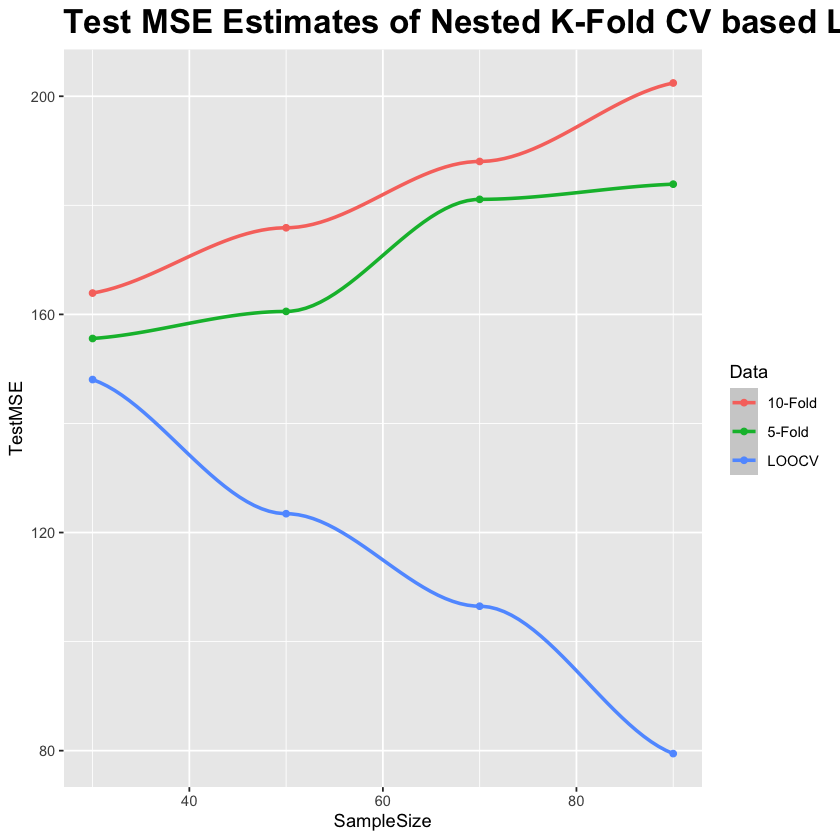

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 29.7”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 40.3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1624.1”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“span too small.   fewer data values than degrees of freedom.”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.fr

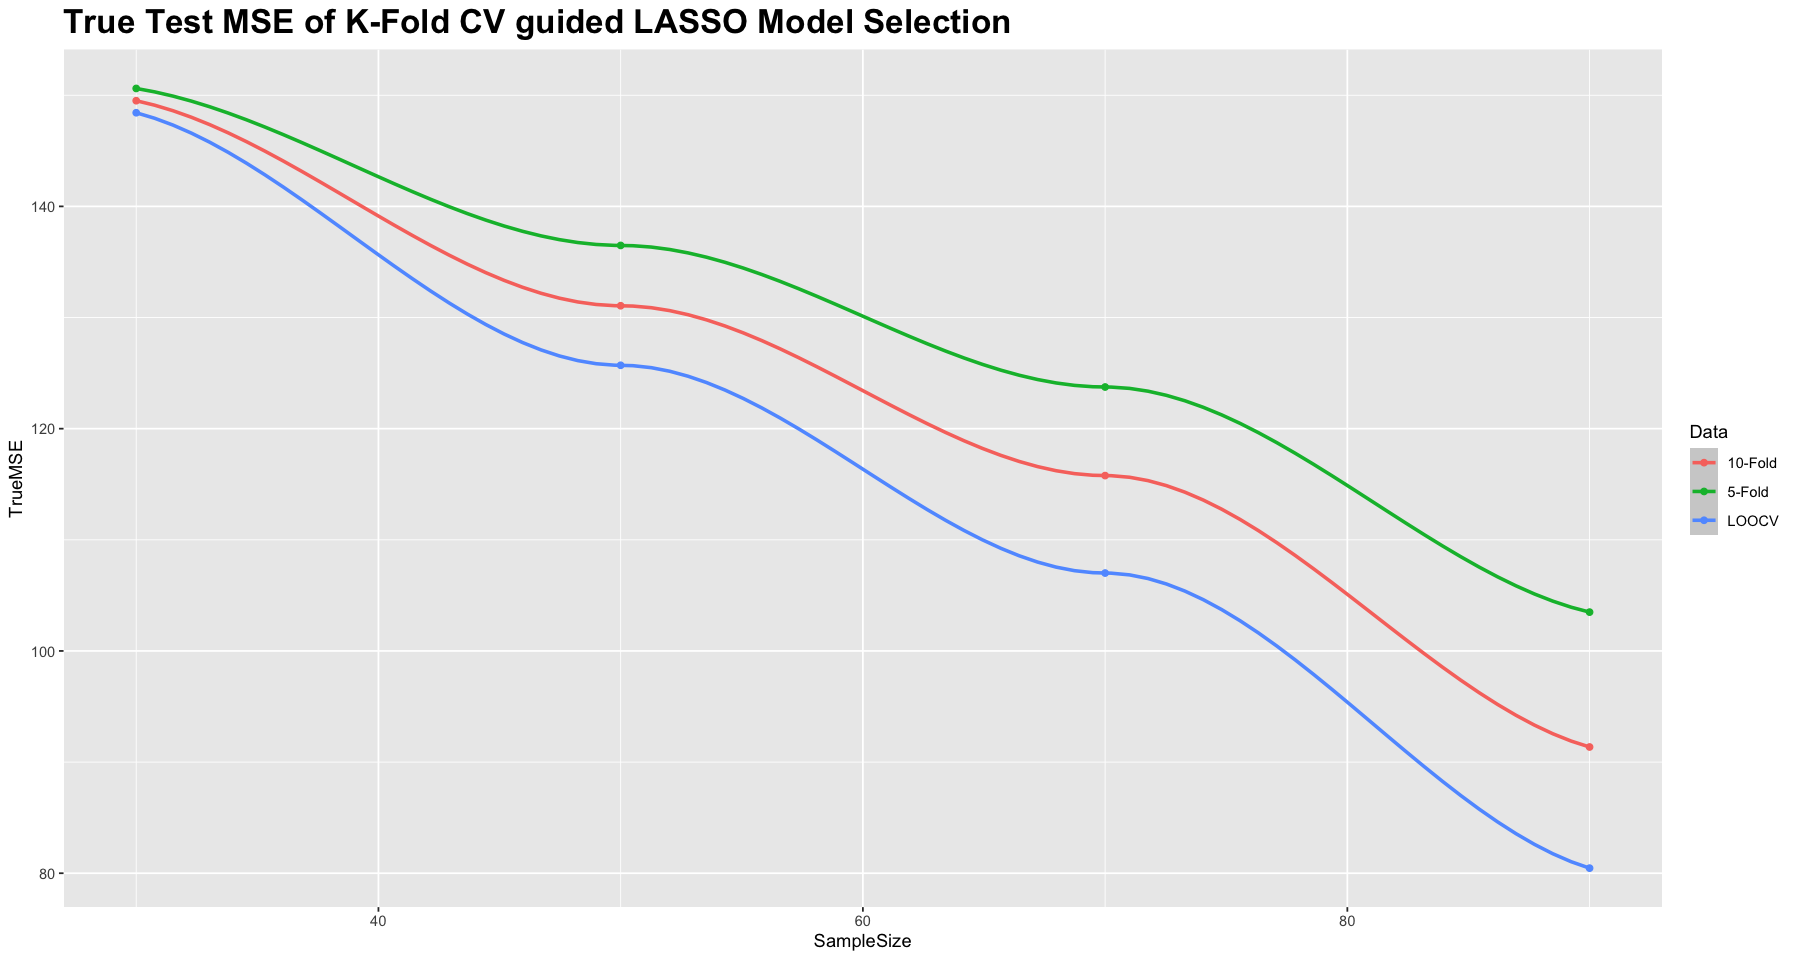

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 29.7”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 40.3”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1624.1”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“span too small.   fewer data values than degrees of freedom.”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.fr

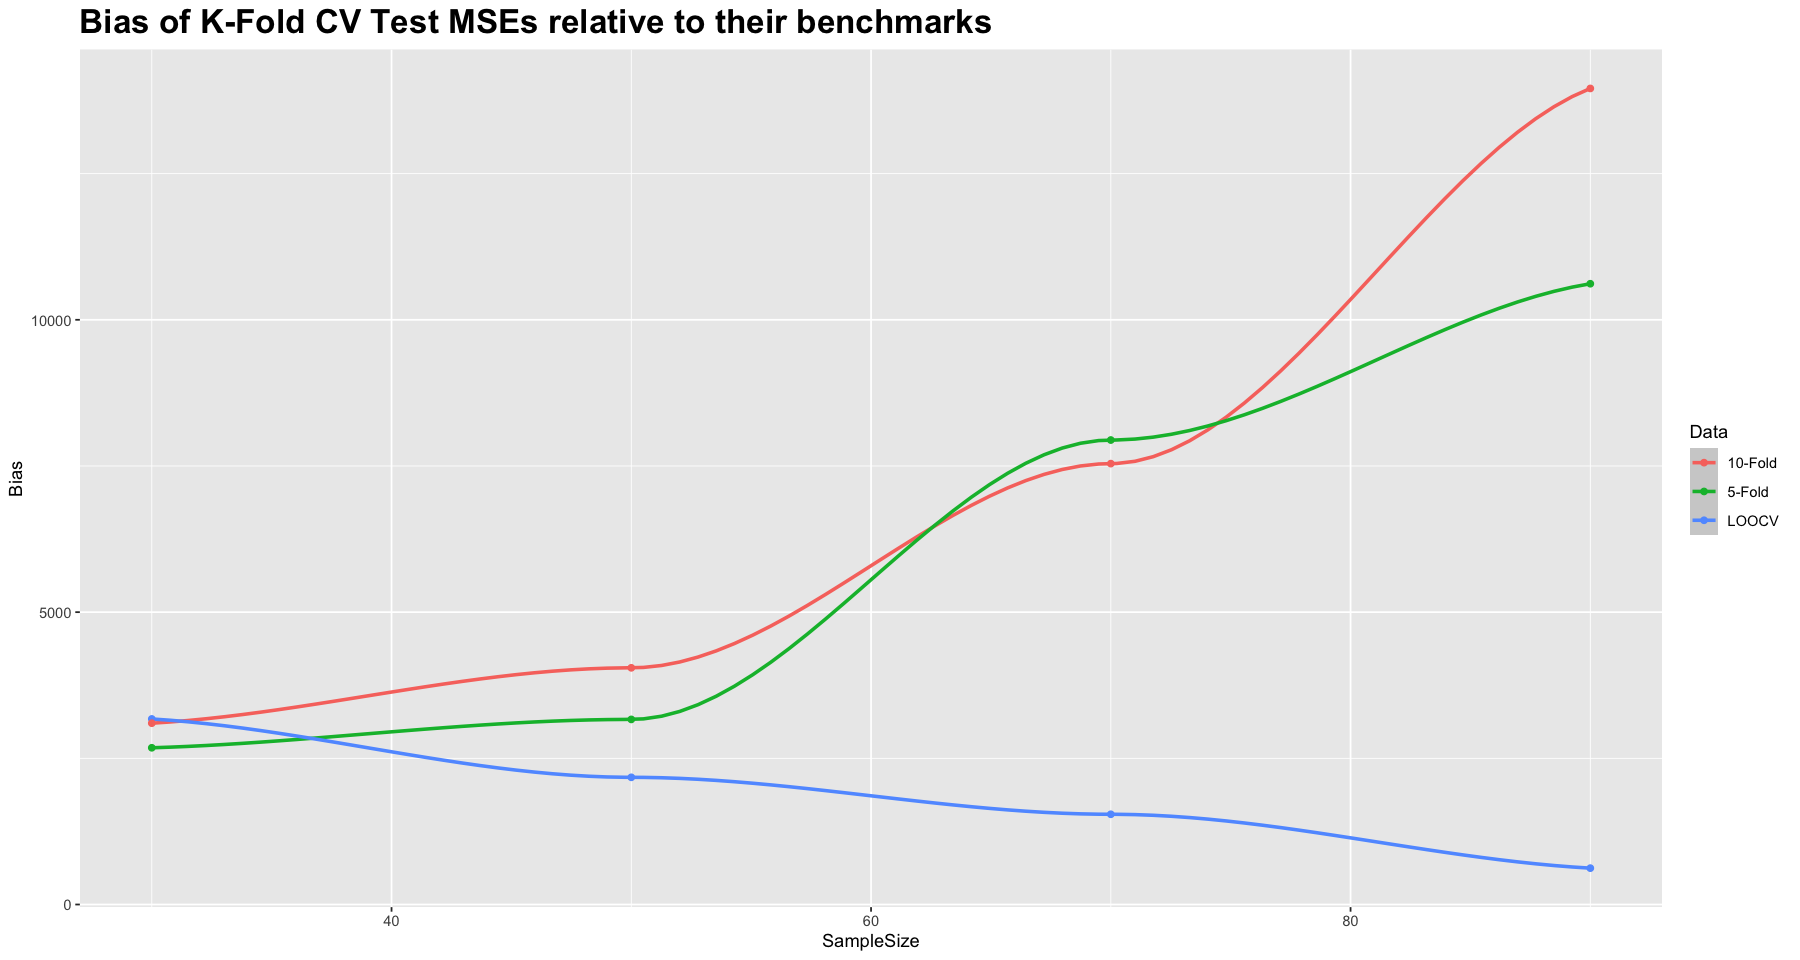

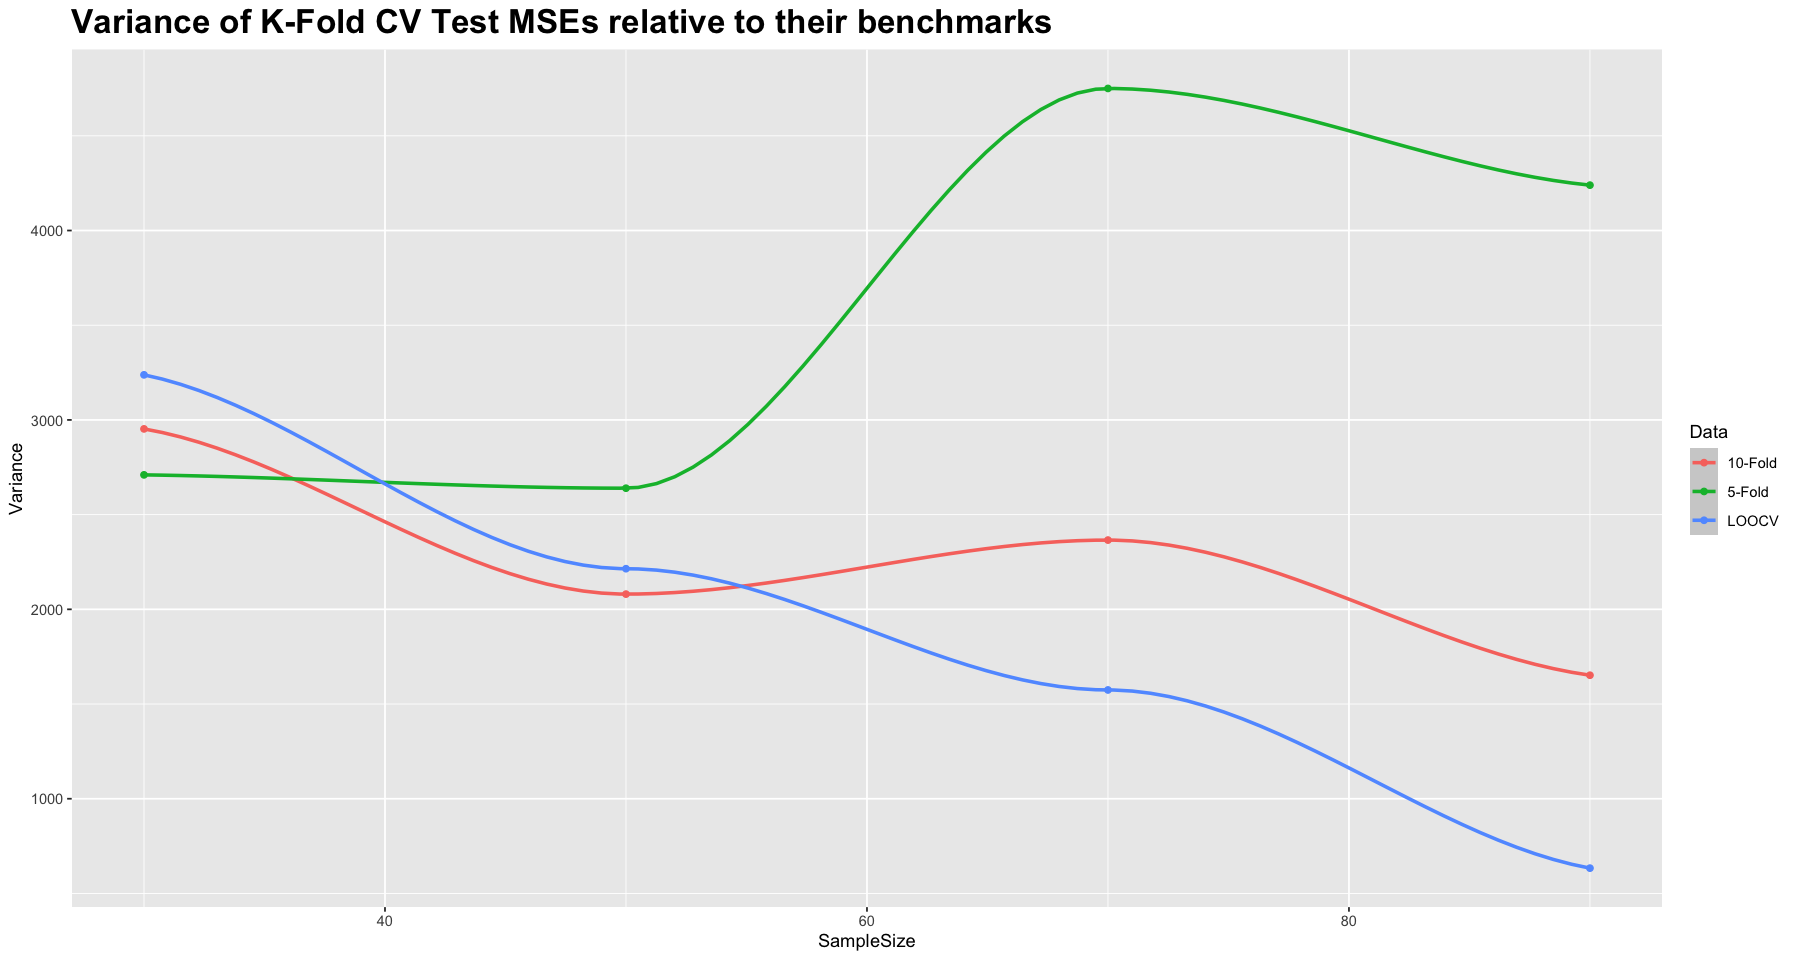

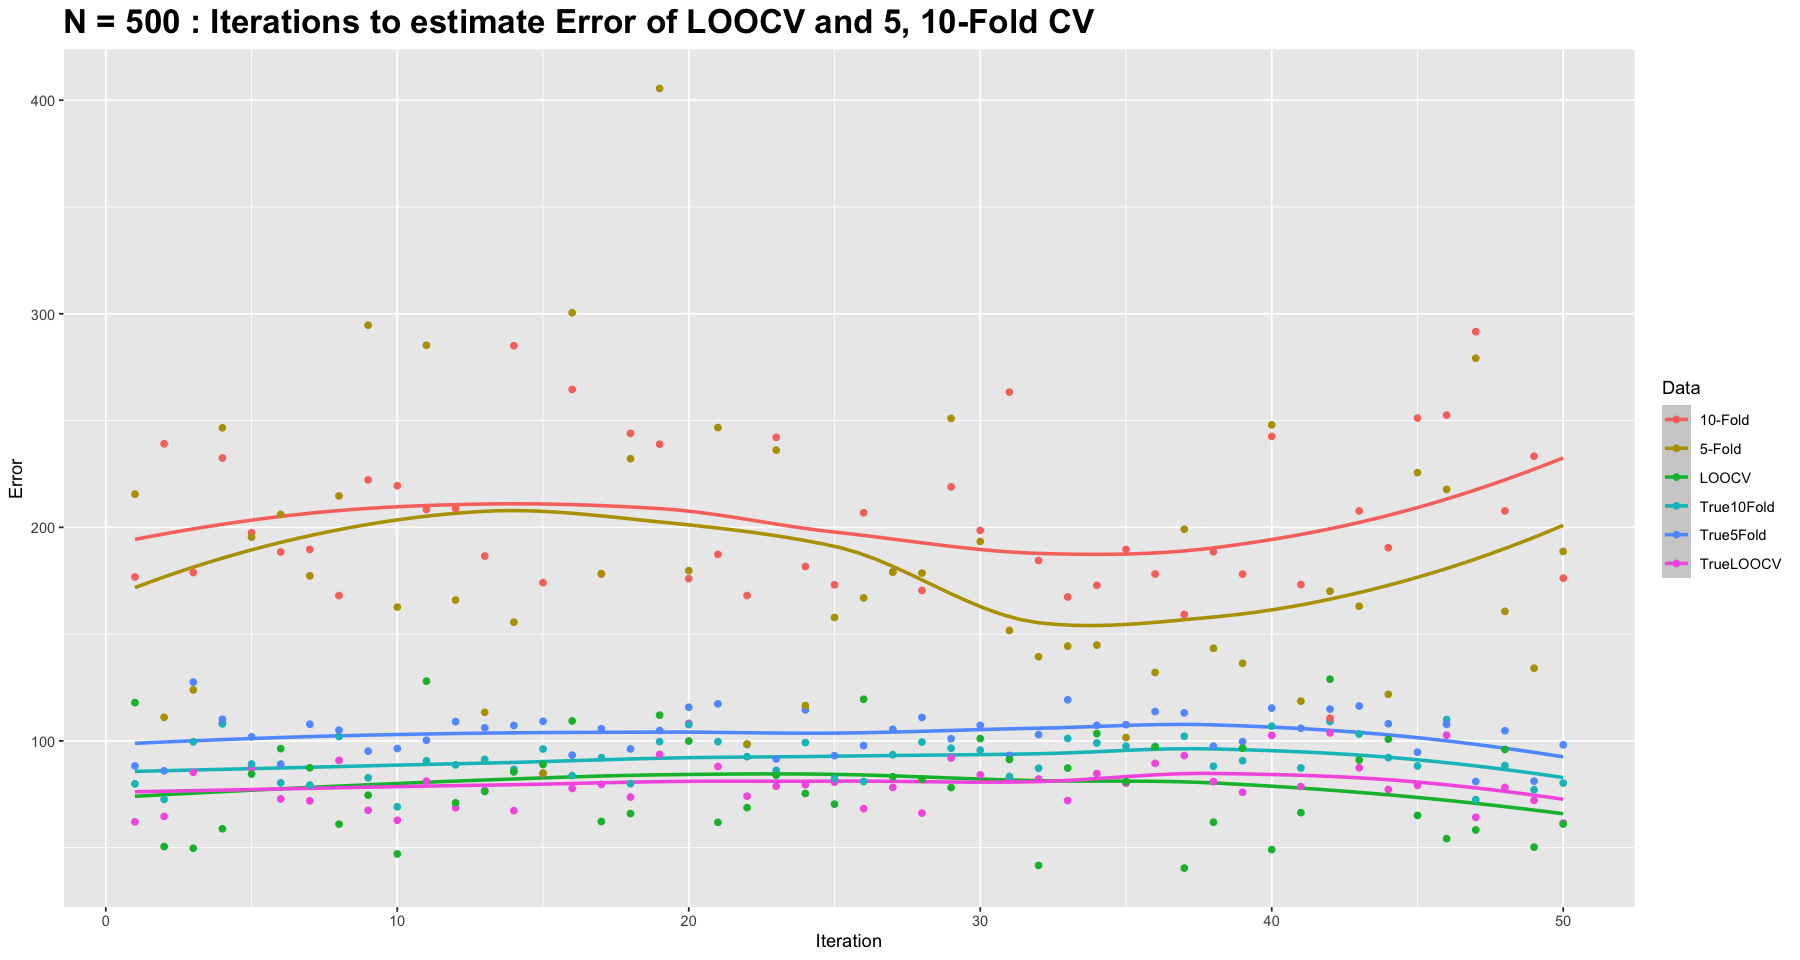

In [243]:
# All the result are organized in a trade-off matrix which will be used to plot graphs
df_true_error <- data.frame(c(rep("LOOCV",sim), rep("10-Fold",sim), rep("5-Fold",sim)),
    c(test_error.matrix[,1],test_error.matrix[,2], test_error.matrix[,3]),
    c(true_error.matrix[,1],true_error.matrix[,2], true_error.matrix[,3]),
    c(bias_matrix[,1],bias_matrix[,2], bias_matrix[,3]),
    c(var_matrix[,1],var_matrix[,2], var_matrix[,3]),           
    rep(sample_size,3))
colnames(df_true_error)<-c("Data","TestMSE","TrueMSE","Bias","Variance","SampleSize")

df_errors <- data.frame(c(rep("TrueLOOCV",rep),rep("True10Fold",rep), rep("True5Fold",rep), 
                          rep("LOOCV",rep), rep("10-Fold",rep), rep("5-Fold",rep)),rep(1:rep,6),
                        c(true_mse.matrix[,1],true_mse.matrix[,2],true_mse.matrix[,3],
                          test_mse.matrix[,1],test_mse.matrix[,2],test_mse.matrix[,3]))
colnames(df_errors)<-c("Data","Iteration","Error")

# Plot the Test MSE Estimates at increasing Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=TestMSE, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("Test MSE Estimates of Nested K-Fold CV based LASSO") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Generalized (true) Error at increasing Sample Sizes (benchmark)
ggplot(data=df_true_error, aes(x=SampleSize, y=TrueMSE, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("True Test MSE of K-Fold CV guided LASSO Model Selection") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the relative Bias against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=Bias, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("Bias of K-Fold CV Test MSEs relative to their benchmarks") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Variance against Sample Sizes
ggplot(data=df_true_error, aes(x=SampleSize, y=Variance, group=Data, colour=Data)) +
    geom_smooth(method="loess", formula = y ~ x, se=TRUE, fullrange=FALSE, level = 0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.50,0.065), xlim=c(0.0005, 0.004)) +
    ggtitle("Variance of K-Fold CV Test MSEs relative to their benchmarks") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

# Plot the Errors when N = 500
ggplot(data=df_errors, aes(x=Iteration, y=Error, group=Data, colour=Data)) +
    geom_smooth(method="loess", se=TRUE, formula = y ~ x, fullrange=FALSE, level=0.01) +
    geom_point() + 
    #coord_cartesian(ylim=c(0.01,0.3)) +
    ggtitle("N = 500 : Iterations to estimate Error of LOOCV and 5, 10-Fold CV") + theme(plot.title = 
    element_text(color="black", face="bold", size=20)) 
options(repr.plot.width=15, repr.plot.height=8)

In [1]:
lambda.matrix  
test_mse.matrix
true_mse.matrix 

test_error.matrix 
true_error.matrix 
bias_matrix  
var_matrix   

ERROR: Error in eval(expr, envir, enclos): object 'lambda.matrix' not found
